## Import libraries

In [1]:
import sys
sys.path.append("/home/jovyan/work/sem-covid/")
sys.path = list(set(sys.path))
import os

os.getcwd()
os.chdir('/home/jovyan/work/sem-covid/')

from sem_covid.services.store_registry import StoreRegistry
from pycaret.utils import check_metric
from pycaret.classification import *

## Load dataset

In [2]:
feature_store = StoreRegistry.es_feature_store()
dataset_x = feature_store.get_features('fs_pwdb_tg1_x')
dataset_y = feature_store.get_features('fs_pwdb_tg1_y')
dataset = dataset_x
dataset['200'] = dataset_y['businesses'].values

100% (1288 of 1288) |####################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (1288 of 1288) |####################| Elapsed Time: 0:00:00 Time:  0:00:00


## Split dataset in train_set and test_set

In [58]:
train_data = dataset.sample(frac=0.70, random_state=786)
test_data = dataset.drop(train_data.index)
train_data.reset_index(inplace=True, drop=True)
test_data.reset_index(inplace=True, drop=True)
print('Data for Modeling: ' + str(train_data.shape))
print('Unseen Data For Predictions: ' + str(test_data.shape))

Data for Modeling: (902, 201)
Unseen Data For Predictions: (386, 201)


## Setup PyCaret

In [59]:
exp_clf101 = setup(data = train_data, target = '200', session_id=123)

,Description,Value
0,session_id,123
1,Target,200
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(902, 201)"
5,Missing Values,False
6,Numeric Features,200
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


## Select best model

In [60]:
best_model = compare_models()


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7575,0.7836,0.5423,0.7144,0.6143,0.4417,0.4524,0.1390
gbc,Gradient Boosting Classifier,0.7401,0.7706,0.5381,0.6789,0.5963,0.4081,0.4174,0.2740
ridge,Ridge Classifier,0.7339,0.0000,0.4577,0.6880,0.5467,0.3698,0.3868,0.0040
rf,Random Forest Classifier,0.7290,0.7606,0.4217,0.6922,0.5213,0.3488,0.3707,0.0650
lda,Linear Discriminant Analysis,0.7149,0.7377,0.5733,0.6103,0.5833,0.3687,0.3737,0.0070
et,Extra Trees Classifier,0.7147,0.7635,0.3589,0.6826,0.4650,0.2988,0.3288,0.0400
ada,Ada Boost Classifier,0.7099,0.7504,0.5874,0.5932,0.5892,0.3653,0.3660,0.0650
nb,Naive Bayes,0.7084,0.7611,0.6955,0.5769,0.6287,0.3932,0.3993,0.0050
knn,K Neighbors Classifier,0.7036,0.7272,0.5326,0.5874,0.5540,0.3343,0.3382,0.1080
lr,Logistic Regression,0.7005,0.7649,0.2198,0.8159,0.3397,0.2185,0.3013,0.1610


## Display best model config

In [61]:
print(best_model)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


## Create model by best_model name

In [62]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7656,0.8324,0.6087,0.7000,0.6512,0.4760,0.4786
1,0.7619,0.7417,0.5455,0.7059,0.6154,0.4470,0.4548
2,0.7778,0.7827,0.5909,0.7222,0.6500,0.4896,0.4949
3,0.8095,0.7528,0.5909,0.8125,0.6842,0.5527,0.5670
4,0.7619,0.8215,0.5000,0.7333,0.5946,0.4345,0.4504
5,0.7778,0.8681,0.5455,0.7500,0.6316,0.4781,0.4905
6,0.7937,0.8758,0.5000,0.8462,0.6286,0.4985,0.5315
7,0.6667,0.6164,0.4545,0.5263,0.4878,0.2427,0.2441
8,0.6508,0.6793,0.4783,0.5238,0.5000,0.2326,0.2331
9,0.8095,0.8652,0.6087,0.8235,0.7000,0.5650,0.5789


## Tune the selected model

In [70]:
tuned_lightgbm = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7812,0.8112,0.5652,0.7647,0.6500,0.4961,0.5081
1,0.7143,0.7406,0.5000,0.6111,0.5500,0.3438,0.3475
2,0.7460,0.7705,0.5455,0.6667,0.6000,0.4167,0.4212
3,0.7302,0.7007,0.4091,0.6923,0.5143,0.3442,0.3670
4,0.7937,0.8049,0.6364,0.7368,0.6829,0.5312,0.5343
5,0.7460,0.8437,0.4545,0.7143,0.5556,0.3898,0.4093
6,0.7937,0.8647,0.5909,0.7647,0.6667,0.5208,0.5299
7,0.7302,0.6585,0.5909,0.6190,0.6047,0.4000,0.4002
8,0.6349,0.6707,0.4783,0.5000,0.4889,0.2052,0.2053
9,0.7778,0.8054,0.5652,0.7647,0.6500,0.4925,0.5046


## Display confusion matrix for tuned model

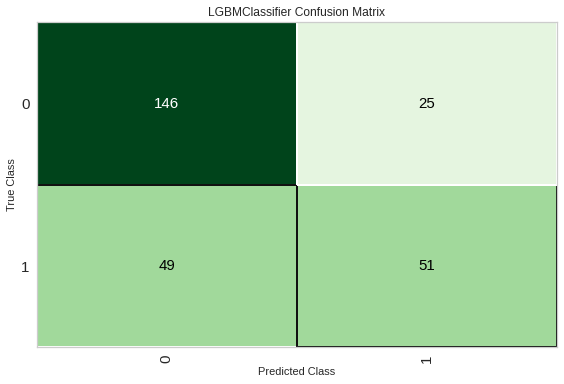

In [71]:
plot_model(tuned_lightgbm, plot = 'confusion_matrix')

## Finalize selected model

In [65]:
final_lightgbm = finalize_model(tuned_lightgbm)

## Predict with test_data

In [66]:
unseen_predictions = predict_model(final_lightgbm, data=test_data)
unseen_predictions.head()

,0,1,2,3,4,5,6,7,8,9,...,193,194,195,196,197,198,199,200,Label,Score
0,0.093630,0.080533,-0.012007,0.006595,-0.105211,0.168381,0.011074,-0.295649,0.094092,-0.026169,...,-0.015453,0.096660,-0.008676,-0.025743,-0.126346,0.100612,0.076976,0,0,0.8179
1,0.032975,0.076163,0.008268,0.034589,-0.059776,0.113442,-0.003348,-0.266979,0.076205,-0.003748,...,-0.045620,0.108454,-0.000835,-0.071349,-0.088752,0.035207,0.090321,0,0,0.9686
2,0.005507,0.039720,0.031400,0.056476,-0.037889,0.082262,-0.001815,-0.288269,0.070536,0.036158,...,-0.034709,0.137928,-0.013249,-0.073035,-0.070765,0.020256,0.089895,1,0,0.5749
3,0.024744,0.070013,0.004319,0.038918,-0.013805,0.119969,-0.012189,-0.288481,0.044286,-0.018195,...,-0.050423,0.041680,-0.009116,-0.067431,-0.059024,0.055563,0.123329,1,1,0.5187
4,0.024454,0.067737,0.035270,0.042665,-0.087353,0.128697,-0.004872,-0.301289,0.087328,0.014337,...,-0.059373,0.060570,0.003512,-0.072368,-0.051577,0.004917,0.100167,0,0,0.9369


## Display F1 score for predictions

In [69]:
check_metric(unseen_predictions['200'], unseen_predictions['Label'], metric = 'F1')


0.5556